# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from get_adult_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7
})


## 2. Configuration

In [2]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.25       # Binary Label Noise probability
#disc_factor = np.pi/2     # Similarity of Y_sen to X
#n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                 # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= -2
lmd_end= 2
lmd_interval = np.linspace(lmd_start, lmd_end, 200)
symmetric_fairness = False

## 3. Data Generation

In [3]:
X_train, Y_train, Y_sen_train, X_test, Y_test, Y_sen_test = get_adult_data()
Y_train_corrupted = add_sym_noise(Y_train, flip_prob, rnd_seed)
Y_sen_train_corrupted = add_sym_noise(Y_sen_train, 0, rnd_seed) #We don't need to extra corrupt the sensitive attribute, because we already corrupted the input.

print(np.mean(Y_train == 1), np.mean(Y_sen_train == 1))


[0 1]
0.24081695331695332 0.3308046683046683


## 4. Model Training

In [4]:
# Initialize and train models
p_reg = LogisticRegression( max_iter=1000).fit(X_train, Y_train)
p_reg_cor = LogisticRegression( max_iter=1000).fit(X_train, Y_train_corrupted)
f_reg = LogisticRegression( max_iter=1000).fit(X_train, Y_sen_train)
f_reg_cor = LogisticRegression( max_iter=1000).fit(X_train, Y_sen_train_corrupted)

Y_pred = p_reg.predict(X_test)
calc_ACC(Y_pred, Y_test)

0.8323813033597445

## 6. Metric Calculation: BER and Fairness

In [5]:
# Sweep over lambda values and calculate metrics
BER_list = []
MD_list = []
DI_list = []
ACC_list = []
BER_list_corr = []
MD_list_corr = []
DI_list_corr = []
ACC_list_corr = []

# lmd = how important is fairness
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)
    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
    DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
    ACC = calc_ACC(Y_pred, Y_test)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)
    ACC_list.append(ACC)


# Compute now with Corrupted labels
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s_2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg_cor.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred_2 = np.where(s_2 > 0, 1, 0)
    BER_2 = calc_BER(Y_pred_2, Y_test)
    MD_2 = calc_MD(Y_pred_2, Y_sen_test, symmetric_fairness)
    DI_2 = calc_DI(Y_pred_2, Y_sen_test, symmetric_fairness)
    ACC_2 = calc_ACC(Y_pred_2, Y_test)
    
    BER_list_corr.append(BER_2)
    MD_list_corr.append(MD_2)
    DI_list_corr.append(DI_2)
    ACC_list_corr.append(ACC_2)

# Store results in DataFrame
results = pd.DataFrame({
    'lambda': lmd_interval,
    'BER_clean': BER_list,
    'MD_clean': MD_list,
    'DI_clean': DI_list,
    'BER_corr': BER_list_corr,
    'MD_corr': MD_list_corr,
    'DI_corr': DI_list_corr,
    'ACC_clean': ACC_list,
    'ACC_corr': ACC_list_corr
})

/tmp/ipykernel_94494/2627520304.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


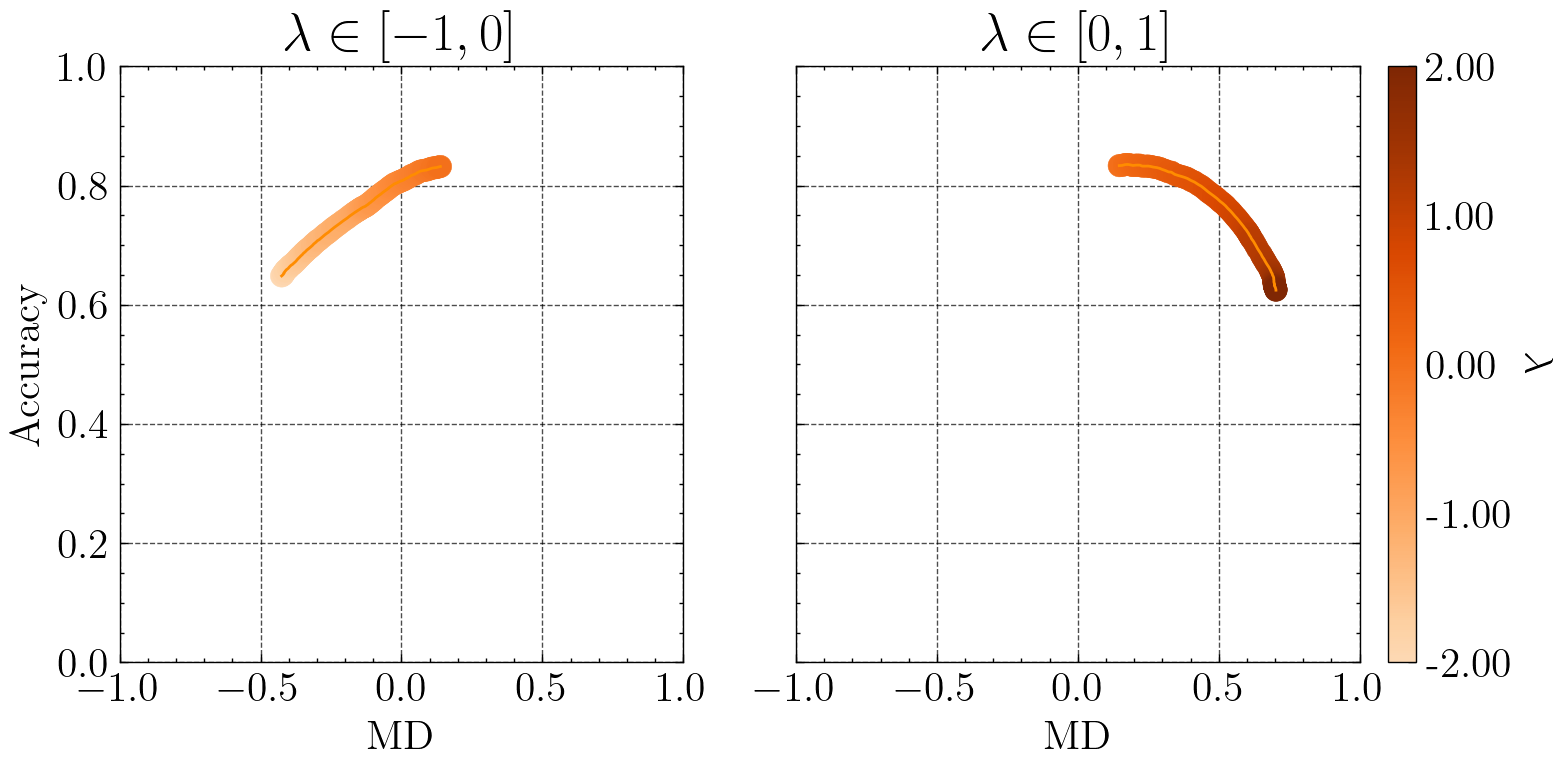

In [ ]:
import matplotlib as mpl

# Global normalization across all λ values
norm = mpl.colors.Normalize(vmin=results["lambda"].min(), vmax=results["lambda"].max())
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.87), sharey=True)

# --- Left subplot (λ ∈ [-1,0]) ---
df_left = results[results["lambda"] <= 0].sort_values(by="lambda")
ax1.plot(df_left["MD_clean"], df_left["ACC_clean"],
         color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

ax1.scatter(df_left["MD_clean"], df_left["ACC_clean"],
            c=df_left["lambda"], cmap=orange_cmap, norm=norm,
            label="Clean", linewidths=0.2, s=65)

ax1.set_title(r"$\lambda \in [-1,0]$")
ax1.set_xlabel("MD")
ax1.set_ylabel("Accuracy")
ax1.set_xlim(-1, 1)
ax1.set_ylim(0, 1)

# --- Right subplot (λ ∈ [0,1]) ---
df_right = results[results["lambda"] >= 0].sort_values(by="lambda")
ax2.plot(df_right["MD_clean"], df_right["ACC_clean"],
         color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

sc = ax2.scatter(df_right["MD_clean"], df_right["ACC_clean"],
                 c=df_right["lambda"], cmap=orange_cmap, norm=norm,
                 label="Clean", linewidths=0.2, s=65)

ax2.set_title(r"$\lambda \in [0,1]$")
ax2.set_xlabel("MD")
ax2.set_xlim(-1, 1)
ax2.set_ylim(0, 1)

# --- One shared colorbar (for both subplots) ---
# Add colorbar
cax = inset_axes(ax2,
                width="5%",
                height="100%",
                loc='center right',
                bbox_to_anchor=(0.1, 0, 1, 1),
                bbox_transform=ax2.transAxes,
                borderpad=0)
    
cbar = fig.colorbar(sc, ax=[ax1, ax2], cax=cax,  orientation="vertical", fraction=0.05, pad=0.04)
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)

# Ticks
lambda_min, lambda_max = results["lambda"].min(), results["lambda"].max()
ticks = np.linspace(lambda_min, lambda_max, 5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{v:.2f}" for v in ticks])

#fig.tight_layout()
fig.show()

## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
